#**Preliminary information**#

This notebook contains two separate models: **model a** and **model b** that are joined in the "one after another" manner to implement **task a+b**. Model b **is loaded**, its training code can be found in the corresponding notebook. Pre-trained HuggingFace transformers are used in both cases.

#**Imports and set up**#

In [1]:
!pip install torchtext --upgrade
!pip install pytorch_lightning
!pip install transformers

Requirement already up-to-date: torchtext in /usr/local/lib/python3.7/dist-packages (0.10.0)
     |████████████████████████████████| 819kB 12.5MB/s 
     |████████████████████████████████| 645kB 34.1MB/s 
     |████████████████████████████████| 122kB 36.8MB/s 
     |████████████████████████████████| 235kB 35.7MB/s 
     |████████████████████████████████| 10.6MB 37.3MB/s 
     |████████████████████████████████| 829kB 33.8MB/s 
     |████████████████████████████████| 1.3MB 35.7MB/s 
     |████████████████████████████████| 143kB 39.8MB/s 
     |████████████████████████████████| 296kB 37.1MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=ccc58b91f8e3f27331a0183501893cd961a0204e26dfc1f4552e409cd7d3faf6
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
 

In [2]:
#to check if gpu is available
import torch
torch.cuda.is_available()

True

In [3]:
from typing import List, Dict
import json
import torch
from bs4 import BeautifulSoup
import requests
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string
import itertools
from tqdm.autonotebook import tqdm
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import random

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
#for the repeatability of the experiments
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# **Data and preprocessing**#

In [5]:
#get data
!git clone https://github.com/SapienzaNLP/nlp2021-hw2/

Cloning into 'nlp2021-hw2'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 32 (delta 10), reused 18 (delta 3), pack-reused 0
Unpacking objects: 100% (32/32), done.


In [6]:
#datasets paths
restaurants_dev = 'nlp2021-hw2/data/restaurants_dev.json'
restaurants_train = 'nlp2021-hw2/data/restaurants_train.json'

laptops_dev = 'nlp2021-hw2/data/laptops_dev.json'
laptops_train = 'nlp2021-hw2/data/laptops_train.json'

In [7]:
#get dataset from path
def read_dataset(path: str) -> List[Dict]:

    with open(path, "r") as f:
        samples = json.load(f)

    return samples

Different experiemnts with datasets were performed. The function below allows to choose which dataset we are going to use for the training, and which one - for the evaluation.

**r** stands for the restaurants, **l** - for the laptops, and **m** means mixed.

In [8]:
def datasets_setup(mode):

      restaurants_train_samples = read_dataset(restaurants_train)
      restaurants_dev_samples = read_dataset(restaurants_dev)

      laptops_train_samples = read_dataset(laptops_train)
      laptops_dev_samples = read_dataset(laptops_dev)

      if mode == 'rr':
        return restaurants_train_samples, restaurants_dev_samples
      if mode == 'rl':
        return restaurants_train_samples, laptops_dev_samples
      if mode == 'rm':
        return restaurants_train_samples, restaurants_dev_samples + laptops_dev_samples

      if mode == 'lr':
        return laptops_train_samples, restaurants_dev_samples
      if mode == 'll':
        return laptops_train_samples, laptops_dev_samples
      if mode == 'lm':
        return laptops_train_samples, restaurants_dev_samples + laptops_dev_samples

      if mode == 'mr':
        return restaurants_train_samples + laptops_train_samples, restaurants_dev_samples
      if mode == 'ml':
        return restaurants_train_samples + laptops_train_samples, laptops_dev_samples
      if mode == 'mm':
        return restaurants_train_samples + laptops_train_samples, restaurants_dev_samples + laptops_dev_samples
        
train_samples, dev_samples = datasets_setup('rr')
print(len(train_samples), len(dev_samples))

2500 541


#**Task a**#

**AspectExtractionDataset** class first performs reframing of a dataset into Pandas dataframe and then applies tokenizer to digitalize representation for the network input. 

Dataframe looks correspondingly to the task a input and consists of 3 columns:

1) sentence as it given, 

2) aspect, 

3) label, 

where aspect is each token of a sentence obtained from it by word_tokenize, and labels correspond to binary classification problem (0 $-$ unrelated, 1 $-$ related), i.e. for each sentence and each token we want our model to predict if this token is related or unrelated to this sentence, i.e. if this token a part of an aspect term or not.

Pretrained tokenizer for the **DistilBert** is used.

In [9]:
class AspectExtractionDataset(Dataset):

    def __init__(self, model_name: str, samples: dict):

        data = []
        for i, sample in enumerate(samples):
          sentence = sample["text"]
          gt_term = {term_gt[1] for term_gt in sample["targets"]}
          targets = set(itertools.chain(*[word_tokenize(i) for i in gt_term]))

          aspect_labels = {aspect: "related" if aspect in targets else "unrelated" 
                          for aspect in word_tokenize(sentence)}

          for aspect, aspect_label in aspect_labels.items(): 
            data += [{
                "sentence_id": i,
                "sentence": sentence,
                "aspect": aspect,
                "label": aspect_label
                }]

        self.dataframe =  pd.DataFrame(data)
        self.model_name = model_name
        self.inputs = self.apply_tokenizer(self.dataframe)

    def apply_tokenizer(self, dataframe: pd.DataFrame):

        tokenizer = AutoTokenizer.from_pretrained(self.model_name)

        labels_dict = {"unrelated": 0, "related": 1}

        labels = list(dataframe.label.apply(lambda x: labels_dict[x]))

        tokenized = tokenizer(list(dataframe.sentence), list(dataframe.aspect), 
                            padding = True, truncation = True, max_length = 512, return_tensors = "pt")
        
        inputs = torch.utils.data.TensorDataset(tokenized["input_ids"], tokenized["attention_mask"], 
                                                torch.tensor(labels, dtype = torch.long).reshape(-1, 1))
        return inputs


    def __len__(self):
      return len(self.dataframe)

    def __getitem__(self, idx):
      return self.inputs[idx]
        

Pytorch Lightning data module is used for dataloaders. Test and Validation dataloaders both make of use of dev dataset.

In [10]:
class AspectExtractionDataModule(pl.LightningDataModule):

      def __init__(self, model_name, train_samples, dev_samples, batch_size = 16):
        super(AspectExtractionDataModule, self).__init__()

        self.train_samples = train_samples
        self.dev_samples = dev_samples
        self.batch_size = batch_size
        self.model_name = model_name
        self.setup()

      def setup(self, stage = None):

        self.train = AspectExtractionDataset(self.model_name, self.train_samples)
        self.dev = AspectExtractionDataset(self.model_name, self.dev_samples)

      def train_dataloader(self):
        return DataLoader(self.train, batch_size = self.batch_size, shuffle = True)

      def val_dataloader(self):
        return DataLoader(self.dev, batch_size = self.batch_size)

      def test_dataloader(self):
        return DataLoader(self.dev, batch_size = self.batch_size)



##**Useful prints**##

These subsection is considered for someone who would like to check preprocessing inside dataset class.

In [22]:
# def reframe_dataset(dataset):

#     data = []
#     for i, sample in enumerate(dataset):
#       sentence = sample["text"]
#       gt_term = {term_gt[1] for term_gt in sample["targets"]}
#       targets = set(itertools.chain(*[word_tokenize(i) for i in gt_term]))
     

#       aspect_labels = {aspect: "related" if aspect in targets else "unrelated" 
#                       for aspect in word_tokenize(sentence)}

#       for aspect, aspect_label in aspect_labels.items(): 
#         data += [{
#             "sentence_id": i,
#             "sentence": sentence,
#             "aspect": aspect,
#             "label": aspect_label
#             }]

#     return pd.DataFrame(data)

# train_df = reframe_dataset(train_samples)
# dev_df = reframe_dataset(dev_samples)
# train_df[112:124]


,sentence_id,sentence,aspect,label
112,9,The selection changes frequently but the basic...,The,unrelated
113,9,The selection changes frequently but the basic...,selection,related
114,9,The selection changes frequently but the basic...,changes,unrelated
115,9,The selection changes frequently but the basic...,frequently,unrelated
116,9,The selection changes frequently but the basic...,but,unrelated
117,9,The selection changes frequently but the basic...,the,unrelated
118,9,The selection changes frequently but the basic...,basic,related
119,9,The selection changes frequently but the basic...,dishes,related
120,9,The selection changes frequently but the basic...,are,unrelated
121,9,The selection changes frequently but the basic...,always,unrelated


In [18]:
# def apply_tokenizer(dataframe):

#     tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

#     labels_dict = {"unrelated": 0, "related": 1}

#     labels = list(dataframe.label.apply(lambda x: labels_dict[x]))

#     tokenized = tokenizer(list(dataframe.sentence), list(dataframe.aspect), 
#                          padding = True, truncation = True, max_length = 512, return_tensors = "pt")
    
#     inputs = torch.utils.data.TensorDataset(tokenized["input_ids"], tokenized["attention_mask"], 
#                                             torch.tensor(labels, dtype = torch.long).reshape(-1, 1))
#     return inputs

# train_inputs = apply_tokenizer(train_df)
# dev_inputs = apply_tokenizer(dev_df)
# train_inputs[:10]

(tensor([[  101,  1037,  2540,  2100,  2048, 16784,  2039,   999,   102,  1037,
            102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0],
         [  101,  1037,  2540,  2100,  2048, 16784,  2039,   999,   102,  2540,
           2100,   102,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0

#**Model**#

**AutoModelForSequenceClassification.**from_pretrained(hparams.model_name, num_labels = hparams.num_labels) 

from TRANSFORMERS library is used to load and try different pretrained models of transformers (DistilBert is used for the task a). Apart from this, class gets dataloaders and performs standard training and validation steps, computing some useful metric data.

In [11]:
class AspectExtractionModel():

      def __init__(self, hparams, device, data_module, *args, **kwargs):
        super().__init__()

        self.lr = hparams.lr
        self.epochs = hparams.epochs
        self.num_labels = hparams.num_labels
        self.numeric_labels = hparams.numeric_labels
        self.device = device
        self.model = AutoModelForSequenceClassification.from_pretrained(hparams.model_name, num_labels = hparams.num_labels)
        self.model.to(device)

        self.optimizer = self.configure_optimizers()

        self.train_loader  = data_module.train_dataloader()
        self.dev_loader = data_module.val_dataloader()

      def train(self):

          for epoch in range(self.epochs):

              for idx, (input_ids, attention_mask, labels) in tqdm(enumerate(self.train_loader)):

                  self.optimizer.zero_grad()

                  output = self.model(input_ids = input_ids.to(self.device), attention_mask = attention_mask.to(self.device), labels = labels.to(self.device))

                  loss = output['loss']

                  loss.backward()
                  self.optimizer.step()

              running_loss = 0.0
              steps = 0
              self.confusion = np.zeros([self.num_labels, self.num_labels])

              for idx, (input_ids, attention_mask, labels) in enumerate(self.dev_loader):

                  with torch.no_grad():

                      output = self.model(input_ids = input_ids.to(self.device), 
                                          attention_mask = attention_mask.to(self.device), 
                                          labels = labels.to(self.device))

                      loss, logits = output['loss'], output['logits']

                      self.confusion += confusion_matrix(y_true = labels.flatten().cpu(), 
                                                    y_pred = torch.sigmoid(logits).argmax(-1).cpu(), 
                                                    labels = self.numeric_labels)

                      running_loss += loss.cpu().numpy()
                      steps += 1

              summary = dict(loss = running_loss / steps, accuracy = self.accuracy())
              print(summary)

          self.save_model()

      
      def get_confusion(self):
        return self.confusion

      def save_model(self):
        torch.save(self.model, f"./absa_big_batch_10.pt")
        print("Training is finished.")

      def accuracy(self):
        return self.confusion.trace() / self.confusion.sum().sum()

      def configure_optimizers(self):
        return AdamW(self.model.parameters(), lr = self.lr)

#**Hyperparameters and Training**#

In [12]:
class HParams():
    model_name = "distilbert-base-uncased"
    lr = 2e-5
    numeric_labels = [0, 1]
    num_labels = 2
    epochs = 4
hparams = HParams() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_module = AspectExtractionDataModule(hparams.model_name, train_samples, dev_samples, batch_size = 24)
model_a = AspectExtractionModel(hparams, device, data_module)
# model_a.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

#**Test and Predict**#

First, we plot **confusion matrix** to detect "week spots" of classification and inbalancing issues.

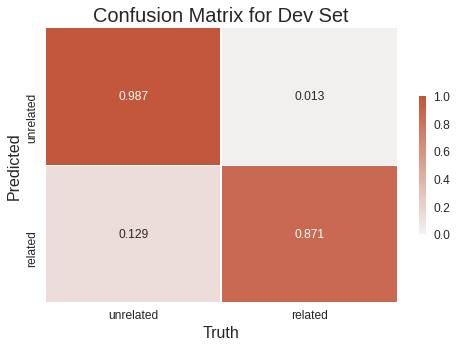

In [ ]:
def draw_confusion_matrix(confusion):
            
    sns.set_theme(style="white")
    plt.style.use("seaborn")
    plt.rcParams.update({
        "figure.titlesize": 26,
        "axes.titlesize": 20,
        "axes.labelsize": 16,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.title_fontsize": 16,
        "legend.fontsize": 12
    })

    labels = ["unrelated", "related"]

    fig, ax = plt.subplots(figsize=(7, 5))
    cmap = sns.diverging_palette(230, 20, as_cmap = True)

    X = confusion / confusion.sum(1, keepdims = True)

    sns.heatmap(
        pd.DataFrame(X, index=labels, columns = labels), 
        cmap = cmap, 
        center = 0,
        vmin = 0,
        vmax = 1,
        annot = True, 
        fmt = ".3f",
        linewidths = .5, 
        cbar_kws = {
            "shrink": .5
        }
    )
    ax.set_title("Confusion Matrix for Dev Set")
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")
    plt.tight_layout()
    plt.show()


confusion = draw_confusion_matrix(model_a.get_confusion())         

AspectExtractionPredict function implements decoding and generates predictions in the form of **list of sets** of predicted aspects: needed to respect signature of evaluate_extraction function provided in the GitHub.

**Note:** if alternative return line was not commented, this function would allow self-testing $-$ we could see what were predicted tokens for each sentence and how they have been transformed to aspect terms.

In [ ]:
def AspectExtractionPredict(model, device, dataset, hparams):

    tokenizer = AutoTokenizer.from_pretrained(hparams.model_name)
    predictions = []
    test_predictions = []
    model.to(device)
    
    for sample in tqdm(dataset):
    
        sentence = sample["text"]
        aspects = word_tokenize(sentence)
        num_aspects = len(aspects)

        tokenized = tokenizer(num_aspects * [sentence], aspects, padding = True, truncation = True, max_length = 512, return_tensors = "pt")

        with torch.no_grad():

            input_ids = tokenized["input_ids"].to(device)
            attention_mask = tokenized["attention_mask"].to(device)

            output = model(input_ids = input_ids, attention_mask = attention_mask)

            logits = output["logits"]

            pred = torch.sigmoid(logits).argmax(-1)
            y_pred = pred.cpu()

            predicted_set = set()
            current_str = str()

            for i, aspect in enumerate(aspects):
                if y_pred[i] == 1 and current_str != '':
                    current_str = current_str + ' ' + aspect
                else:
                  if y_pred[i] == 1:
                    current_str = aspect
                  else:
                    if current_str != '':
                      predicted_set.add(current_str)
                      current_str = ''

            if current_str != '':
                predicted_set.add(current_str)

            test_list = []
            for i, aspect in enumerate(aspects):
                if y_pred[i] == 1:
                  test_list.append(aspect)


                    

            predictions.append(predicted_set)
            test_predictions.append(test_list)
    
    
    #return zip(predictions, test_predictions)
    return predictions

Provided by GitHub.

In [ ]:
def evaluate_extraction(samples, predictions_b):
    scores = {"tp": 0, "fp": 0, "fn": 0}
    printing_interval = 0
    for sample, prediction in zip(samples, predictions_b):
        pred_terms = prediction
        gt_terms = {term_gt[1] for term_gt in sample["targets"]}
        if printing_interval % 50 == 0:
            print("Sample index: ", printing_interval)
            print("Predicted: ", pred_terms)
            print("True: ", gt_terms)
            print('-'*30)
        printing_interval += 1

        scores["tp"] += len(pred_terms & gt_terms)
        scores["fp"] += len(pred_terms - gt_terms)
        scores["fn"] += len(gt_terms - pred_terms)

    precision = 100 * scores["tp"] / (scores["tp"] + scores["fp"])
    recall = 100 * scores["tp"] / (scores["tp"] + scores["fn"])
    f1 = 2 * precision * recall / (precision + recall)
    print(precision)
    print(recall)
    print(f1)

predictions_a = AspectExtractionPredict(model_a.model, device, dev_samples, hparams) 
evaluate_extraction(dev_samples, predictions_a)


Sample index:  0
Predicted:  set()
True:  set()
------------------------------
Sample index:  50
Predicted:  {'reservation', 'table'}
True:  {'reservation', 'table'}
------------------------------
Sample index:  100
Predicted:  set()
True:  set()
------------------------------
Sample index:  150
Predicted:  {'dim sum'}
True:  {'dim sum'}
------------------------------
Sample index:  200
Predicted:  set()
True:  set()
------------------------------
Sample index:  250
Predicted:  set()
True:  {'cost'}
------------------------------
Sample index:  300
Predicted:  set()
True:  set()
------------------------------
Sample index:  350
Predicted:  {'service', 'table', 'server'}
True:  {'service', 'table', 'server'}
------------------------------
Sample index:  400
Predicted:  set()
True:  set()
------------------------------
Sample index:  450
Predicted:  {'food'}
True:  {'food'}
------------------------------
Sample index:  500
Predicted:  {'pasta', 'appetizers', 'steak', 'salads'}
True:  {'

#**Stack with model b**#

We **load model b** and compute predictions of sentiments for those aspect terms that are predcited by model a. AspectSentimentPredict returns **list of sets of pairs** (aspect, sentiment) in order to respect signature of evaluate_sentiment function provided in the GitHub.

In [ ]:
model_b = torch.load(f"absa_b.pt")

In [ ]:
def AspectSentimentPredict(model, device, dataset, hparams_b, predictions_a):

    tokenizer = AutoTokenizer.from_pretrained(hparams_b.model_name)

    sentiment_types = ["positive", "negative", "neutral", "conflict"]

    predictions = []
    test_predictions = []
    for sample, pred in zip(dataset, predictions_a):
    
        sentence = sample["text"]

        aspects = list(pred)
        num_aspects = len(aspects)

        if aspects == []:
          predictions.append([])
          continue

        tokenized = tokenizer(num_aspects * [sentence], aspects, padding = True, truncation = True, max_length = 512, return_tensors = "pt")

        with torch.no_grad():

            input_ids = tokenized["input_ids"].to(device)
            attention_mask = tokenized["attention_mask"].to(device)

            output = model(input_ids = input_ids, attention_mask = attention_mask)

            logits = output["logits"]

            pred = torch.softmax(logits, -1).argmax(-1)
            y_pred = pred.cpu()

            predicted_list = [(aspect, sentiment_types[pred]) for (aspect, pred) in zip(aspects,y_pred)]
        
            true_list = [(aspect[1], sentiment[2]) for (aspect, sentiment) in zip(sample["targets"], sample["targets"])]

            predictions.append(predicted_list)
            test_predictions.append(true_list)
    
    #return zip(predictions, test_predictions)
    return predictions

Provided in GitHub.

In [ ]:
def evaluate_sentiment(samples, predictions_b, mode="Aspect Sentiment"):
    scores = {}

    sentiment_types = ["positive", "negative", "neutral", "conflict"]

    scores = {sent: {"tp": 0, "fp": 0, "fn": 0} for sent in sentiment_types + ["ALL"]}

    for label, pred in zip(samples, predictions_b):
        for sentiment in sentiment_types:

            pred_sent = {(term_pred[0], term_pred[1]) for term_pred in pred if
                                    term_pred[1] == sentiment}
            gt_sent = {(term_pred[1], term_pred[2]) for term_pred in label["targets"] if
                                    term_pred[2] == sentiment}

            scores[sentiment]["tp"] += len(pred_sent & gt_sent)
            scores[sentiment]["fp"] += len(pred_sent - gt_sent)
            scores[sentiment]["fn"] += len(gt_sent - pred_sent)

    # Compute per sentiment Precision / Recall / F1
    for sent_type in scores.keys():
        if scores[sent_type]["tp"]:
            scores[sent_type]["p"] = 100 * scores[sent_type]["tp"] / (scores[sent_type]["fp"] + scores[sent_type]["tp"])
            scores[sent_type]["r"] = 100 * scores[sent_type]["tp"] / (scores[sent_type]["fn"] + scores[sent_type]["tp"])
        else:
            scores[sent_type]["p"], scores[sent_type]["r"] = 0, 0

        if not scores[sent_type]["p"] + scores[sent_type]["r"] == 0:
            scores[sent_type]["f1"] = 2 * scores[sent_type]["p"] * scores[sent_type]["r"] / (
                    scores[sent_type]["p"] + scores[sent_type]["r"])
        else:
            scores[sent_type]["f1"] = 0

    # Compute micro F1 Scores
    tp = sum([scores[sent_type]["tp"] for sent_type in sentiment_types])
    fp = sum([scores[sent_type]["fp"] for sent_type in sentiment_types])
    fn = sum([scores[sent_type]["fn"] for sent_type in sentiment_types])

    if tp:
        precision = 100 * tp / (tp + fp)
        recall = 100 * tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)

    else:
        precision, recall, f1 = 0, 0, 0

    scores["ALL"]["p"] = precision
    scores["ALL"]["r"] = recall
    scores["ALL"]["f1"] = f1
    scores["ALL"]["tp"] = tp
    scores["ALL"]["fp"] = fp
    scores["ALL"]["fn"] = fn

    # Compute Macro F1 Scores
    scores["ALL"]["Macro_f1"] = sum([scores[ent_type]["f1"] for ent_type in sentiment_types])/len(sentiment_types)
    scores["ALL"]["Macro_p"] = sum([scores[ent_type]["p"] for ent_type in sentiment_types])/len(sentiment_types)
    scores["ALL"]["Macro_r"] = sum([scores[ent_type]["r"] for ent_type in sentiment_types])/len(sentiment_types)

    print(f"{mode} Evaluation\n")

    print(
        "\tALL\t TP: {};\tFP: {};\tFN: {}".format(
            scores["ALL"]["tp"],
            scores["ALL"]["fp"],
            scores["ALL"]["fn"]))
    print(
        "\t\t(m avg): precision: {:.2f};\trecall: {:.2f};\tf1: {:.2f} (micro)".format(
            precision,
            recall,
            f1))
    print(
        "\t\t(M avg): precision: {:.2f};\trecall: {:.2f};\tf1: {:.2f} (Macro)\n".format(
            scores["ALL"]["Macro_p"],
            scores["ALL"]["Macro_r"],
            scores["ALL"]["Macro_f1"]))

    for sent_type in sentiment_types:
        print("\t{}: \tTP: {};\tFP: {};\tFN: {};\tprecision: {:.2f};\trecall: {:.2f};\tf1: {:.2f};\t{}".format(
            sent_type,
            scores[sent_type]["tp"],
            scores[sent_type]["fp"],
            scores[sent_type]["fn"],
            scores[sent_type]["p"],
            scores[sent_type]["r"],
            scores[sent_type]["f1"],
            scores[sent_type]["tp"] +
            scores[sent_type][
                "fp"]))

    return scores, precision, recall, f1

class HParamsb():
    model_name = "bert-large-uncased"
hparams_b = HParamsb() 
evaluate_sentiment(dev_samples, AspectSentimentPredict(model_b, device, dev_samples, hparams_b, predictions_a))


Aspect Sentiment Evaluation

	ALL	 TP: 396;	FP: 281;	FN: 264
		(m avg): precision: 58.49;	recall: 60.00;	f1: 59.24 (micro)
		(M avg): precision: 43.14;	recall: 43.25;	f1: 42.26 (Macro)

	positive: 	TP: 251;	FP: 119;	FN: 109;	precision: 67.84;	recall: 69.72;	f1: 68.77;	370
	negative: 	TP: 108;	FP: 96;	FN: 48;	precision: 52.94;	recall: 69.23;	f1: 60.00;	204
	neutral: 	TP: 36;	FP: 60;	FN: 89;	precision: 37.50;	recall: 28.80;	f1: 32.58;	96
	conflict: 	TP: 1;	FP: 6;	FN: 18;	precision: 14.29;	recall: 5.26;	f1: 7.69;	7


({'ALL': {'Macro_f1': 42.25965412508522,
   'Macro_p': 43.14118214853509,
   'Macro_r': 43.25403733693208,
   'f1': 59.23709798055347,
   'fn': 264,
   'fp': 281,
   'p': 58.493353028064995,
   'r': 60.0,
   'tp': 396},
  'conflict': {'f1': 7.692307692307693,
   'fn': 18,
   'fp': 6,
   'p': 14.285714285714286,
   'r': 5.2631578947368425,
   'tp': 1},
  'negative': {'f1': 59.99999999999999,
   'fn': 48,
   'fp': 96,
   'p': 52.94117647058823,
   'r': 69.23076923076923,
   'tp': 108},
  'neutral': {'f1': 32.57918552036199,
   'fn': 89,
   'fp': 60,
   'p': 37.5,
   'r': 28.8,
   'tp': 36},
  'positive': {'f1': 68.76712328767123,
   'fn': 109,
   'fp': 119,
   'p': 67.83783783783784,
   'r': 69.72222222222223,
   'tp': 251}},
 58.493353028064995,
 60.0,
 59.23709798055347)